# Amazon Forecast: predicting time-series at scale

Forecasting is used in a variety of applications and business use cases: For example, retailers need to forecast the sales of their products to decide how much stock they need by location, Manufacturers need to estimate the number of parts required at their factories to optimize their supply chain, Businesses need to estimate their flexible workforce needs, Utilities need to forecast electricity consumption needs in order to attain an efficient energy network, and 
enterprises need to estimate their cloud infrastructure needs.

<img src="BlogImages/amazon_forecast.png">

#  First let us setup Amazon Forecast

This section sets up the permissions and relevant endpoints.

In [209]:
%load_ext autoreload
%autoreload 2
from fcst_utils import *
import warnings
import boto3
import s3fs
plt.rcParams['figure.figsize'] = (15.0, 5.0)
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Although, we have set the region to us-west-2 below, you can choose any of the 6 regions that the service is available in.

In [210]:
region = 'us-west-2'
bucket = 'bike-demo'
version = 'prod'

In [211]:
session = boto3.Session(region_name='us-west-2') 
forecast = session.client(service_name='forecast') 
forecast_query = session.client(service_name='forecastquery')

In [212]:
role_arn = get_or_create_role_arn(session, bucket, version)

# Overview

<img src="BlogImages/outline.png">

<img src="BlogImages/forecast_workflow.png">

The above figure summarizes the key workflow of using Forecast. 

# Step 1: Preparing the Datasets

In [6]:
bike_df = pd.read_csv("../data/train.csv", dtype = object)
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1


In [7]:
bike_df['count'] = bike_df['count'].astype('float')
bike_df['workingday'] = bike_df['workingday'].astype('float')

We take about two and a half week's of hourly data for demonstration, just for the purpose that there's no missing data in the whole range.

In [8]:
bike_df_small = bike_df[-2*7*24-24*3:]
bike_df_small['item_id'] = "bike_12"

Let us plot the time series first.

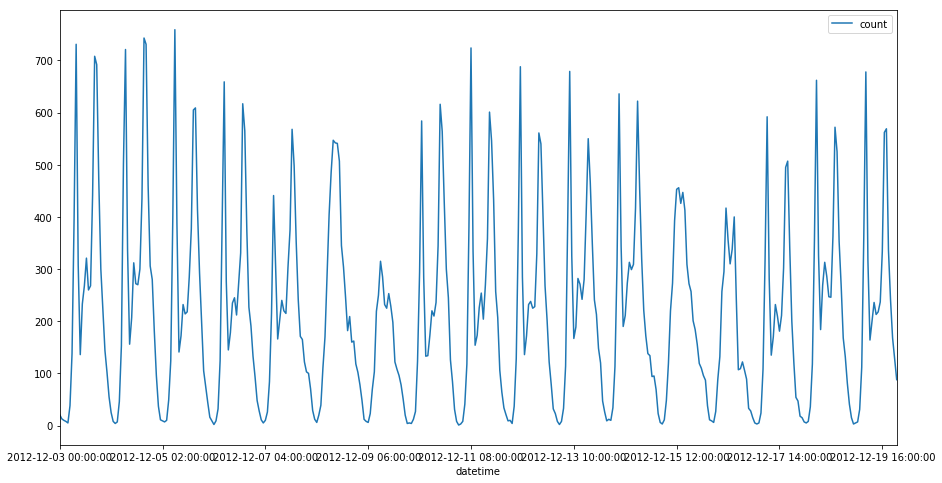

In [192]:
bike_df_small.plot(x='datetime', y='count', figsize=(15, 8))

We can see that the target time series seem to have a drop over weekends. Next let's plot both the target time series and the related time series that indicates whether today is a `workday` or not. More precisely, $r_t = 1$ if $t$ is a work day and 0 if not.

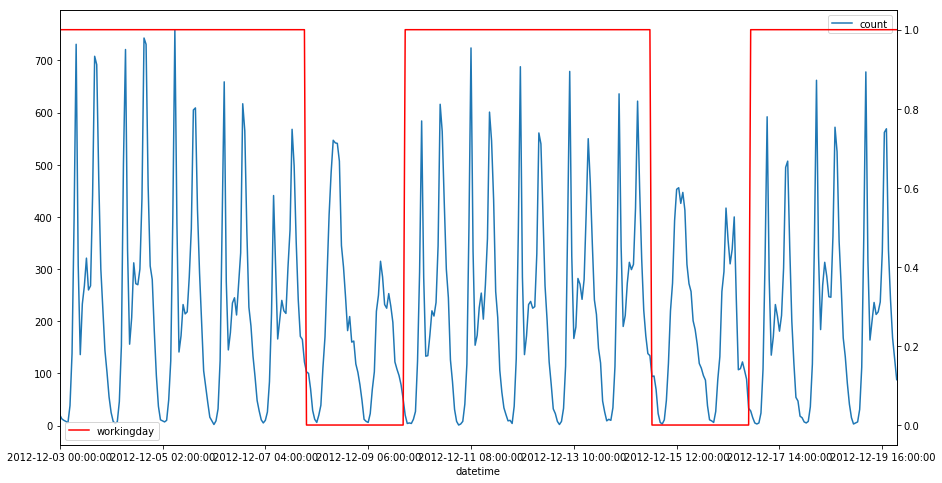

In [109]:
plt.figure(figsize=(15, 8))
ax = plt.gca()
bike_df_small.plot(x='datetime', y='count', ax=ax);
ax2 = ax.twinx()
bike_df_small.plot(x='datetime', y='workingday', color='red', ax=ax2);

Notice that to use the related time series, we need to ensure that the related time series covers the whole target time series, as well as the future values as specified by the forecast horizon. More precisely, we need to make sure:
```
len(related time series) >= len(target time series) + forecast horizon
```
Basically, all items need to have data start at or before the item start date, and have data until the forecast horizon (i.e. the latest end date across all items + forecast horizon).  Additionally, there should be no missing values in the related time series. The following picture illustrates the desired logic. 

<img src="BlogImages/rts_viz.png">

For more details regarding how to prepare your Related Time Series dataset, please refer to the public documentation <a href="https://docs.aws.amazon.com/forecast/latest/dg/related-time-series-datasets.html">here</a>. 

Suppose in this particular example, we wish to forecast for the next 24 hours, and thus we generate the following dataset.

In [12]:
target_df = bike_df_small[['item_id', 'datetime', 'count']][:-24]
rts_df = bike_df_small[['item_id', 'datetime', 'workingday']]

In [14]:
target_df.head(5)

,item_id,datetime,count
10478,bike_12,2012-12-03 00:00:00,21.0
10479,bike_12,2012-12-03 01:00:00,13.0
10480,bike_12,2012-12-03 02:00:00,10.0
10481,bike_12,2012-12-03 03:00:00,8.0
10482,bike_12,2012-12-03 04:00:00,5.0


As we can see, the length of the related time series is equal to the length of the target time series plus the forecast horizon. 

In [200]:
print(len(target_df), len(rts_df))
assert len(target_df) + 24 == len(rts_df), "length doesn't match"

384 408


Next we check whether there are "holes" in the related time series.  

In [16]:
assert len(rts_df) == len(pd.date_range(
    start=list(rts_df['datetime'])[0],
    end=list(rts_df['datetime'])[-1],
    freq='H'
)), "missing entries in the related time series"

Everything looks fine, and we plot both time series again. As it can be seen, the related time series (indicator of whether the current day is a workday or not) is longer than the target time series.  The binary working day indicator feature is a good example of a related time series, since it is known at all future time points.  Other examples of related time series include holiday and promotion features.

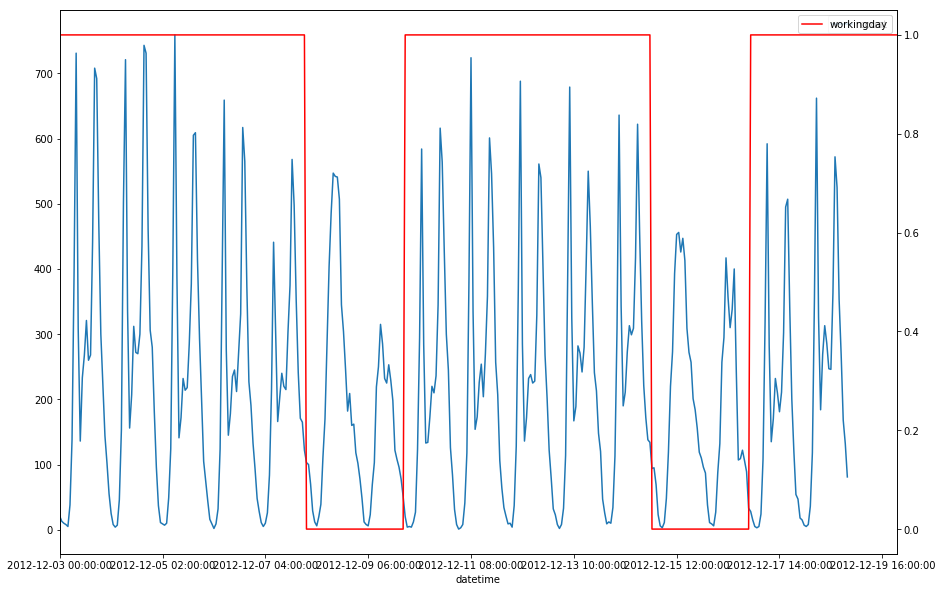

In [17]:
plt.figure(figsize=(15, 10))
ax = plt.gca()
target_df.plot(x='datetime', y='count', ax=ax);
ax2 = ax.twinx()
rts_df.plot(x='datetime', y='workingday', color='red', ax=ax2);

In [18]:
target_df.to_csv("../data/bike_small.csv", index= False, header = False)
rts_df.to_csv("../data/bike_small_rts.csv", index= False, header = False)

In [19]:
s3 = session.client('s3')
account_id = boto3.client('sts').get_caller_identity().get('Account')

In [20]:
bucket_name = f"amazon-forecast-data-{account_id}"
key = "bike_small"

s3.upload_file(Filename="../data/bike_small.csv", Bucket = bucket_name, Key = f"{key}/bike.csv")
s3.upload_file(Filename="../data/bike_small_rts.csv", Bucket = bucket_name, Key = f"{key}/bike_rts.csv")

# Step 2. Importing the Data


Now we are ready to import the datasets into the Forecast service. Starting from the raw data, Amazon Forecast automatically extracts the dataset that is suitable for forecasting. As an example, a retailer normally records the transaction record such as
<img src="BlogImages/data_format.png">
<img src="BlogImages/timestamp.png">



In [117]:
project = "bike_rts_demo"
idx = 4

In [118]:
s3_data_path = f"s3://{bucket_name}/{key}"

Below, we specify key input data and forecast parameters

In [119]:
freq = "H"
forecast_horizon = 24
timestamp_format = "yyyy-MM-dd HH:mm:ss"
delimiter = ','

## Step 2a. Creating a Dataset Group
First let's create a dataset group and then update it later to add our datasets.

In [120]:
dataset_group = f"{project}_gp_{idx}"
dataset_arns = []
create_dataset_group_response = forecast.create_dataset_group(Domain="RETAIL",
                                                          DatasetGroupName=dataset_group,
                                                          DatasetArns=dataset_arns)

In [121]:
logging.info(f'Creating dataset group {dataset_group}')

INFO:root:Creating dataset group bike_rts_demo_gp_4


In [122]:
dataset_group_arn = create_dataset_group_response['DatasetGroupArn']

In [ ]:
forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

## Step 2b. Creating a Target Dataset
In this example, we will define a target time series. This is a required dataset to use the service.

Below we specify the target time series name af_demo_ts_4.

In [124]:
ts_dataset_name = f"{project}_ts_{idx}"
print(ts_dataset_name)

bike_rts_demo_ts_4


Next, we specify the schema of our dataset below. Make sure the order of the attributes (columns) matches the raw data in the files. We follow the same three attribute format as the above example.

In [125]:
ts_schema_val = [{"AttributeName": "item_id", "AttributeType": "string"},
              {"AttributeName": "timestamp", "AttributeType": "timestamp"},
              {"AttributeName": "demand", "AttributeType": "float"}]
ts_schema = {"Attributes": ts_schema_val}

In [126]:
logging.info(f'Creating target dataset {ts_dataset_name}')

INFO:root:Creating target dataset bike_rts_demo_ts_4


In [127]:
response = forecast.create_dataset(Domain="RETAIL",
                               DatasetType='TARGET_TIME_SERIES',
                               DatasetName=ts_dataset_name,
                               DataFrequency=freq,
                               Schema=ts_schema
                              )

In [201]:
ts_dataset_arn = response['DatasetArn']

In [ ]:
forecast.describe_dataset(DatasetArn=ts_dataset_arn)

## Step 2c. Creating a Related Dataset
In this example, we will define a related time series.

Specify the related time series name af_demo_rts_4.

In [130]:
rts_dataset_name = f"{project}_rts_{idx}"
print(rts_dataset_name)

bike_rts_demo_rts_4


Specify the schema of your dataset here. Make sure the order of columns matches the raw data files. We follow the same three column format as the above example.

In [131]:
rts_schema_val = [{"AttributeName": "item_id", "AttributeType": "string"},
              {"AttributeName": "timestamp", "AttributeType": "timestamp"},
              {"AttributeName": "price", "AttributeType": "float"}]
rts_schema = {"Attributes": rts_schema_val}

In [132]:
logging.info(f'Creating related dataset {rts_dataset_name}')

INFO:root:Creating related dataset bike_rts_demo_rts_4


In [133]:
response = forecast.create_dataset(Domain="RETAIL",
                               DatasetType='RELATED_TIME_SERIES',
                               DatasetName=rts_dataset_name,
                               DataFrequency=freq,
                               Schema=rts_schema
                              )

In [202]:
rts_dataset_arn = response['DatasetArn']

In [ ]:
forecast.describe_dataset(DatasetArn=rts_dataset_arn)

## Step 2d. Updating the dataset group with the datasets we created
You can have multiple datasets under the same dataset group. Update it with the datasets we created before.

In [ ]:
dataset_arns = []
dataset_arns.append(ts_dataset_arn)
dataset_arns.append(rts_dataset_arn)
forecast.update_dataset_group(DatasetGroupArn=dataset_group_arn, DatasetArns=dataset_arns)

In [ ]:
forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

## Step 2e. Creating a Target Time Series Dataset Import Job

In [139]:
ts_s3_data_path = f"{s3_data_path}/bike.csv"

In [140]:
ts_dataset_import_job_response = forecast.create_dataset_import_job(DatasetImportJobName=dataset_group,
                                                             DatasetArn=ts_dataset_arn,
                                                             DataSource= {
                                                                 "S3Config" : {
                                                                     "Path": ts_s3_data_path,
                                                                     "RoleArn": role_arn
                                                                 } 
                                                             },
                                                             TimestampFormat=timestamp_format)

In [141]:
ts_dataset_import_job_arn=ts_dataset_import_job_response['DatasetImportJobArn']

In [142]:
status = wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))
assert status

......

INFO:root:Finished in 210 seconds with status success


## Step 2f. Creating a Related Time Series Dataset Import Job

In [143]:
rts_s3_data_path = f"{s3_data_path}/bike_rts.csv"

In [144]:
rts_dataset_import_job_response = forecast.create_dataset_import_job(DatasetImportJobName=dataset_group,
                                                             DatasetArn=rts_dataset_arn,
                                                             DataSource= {
                                                                 "S3Config" : {
                                                                     "Path": rts_s3_data_path,
                                                                     "RoleArn": role_arn
                                                                 } 
                                                             },
                                                             TimestampFormat=timestamp_format)

In [145]:
rts_dataset_import_job_arn=rts_dataset_import_job_response['DatasetImportJobArn']

In [146]:
status = wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=rts_dataset_import_job_arn))
assert status

....

INFO:root:Finished in 150 seconds with status success


# Step 3. Choosing an algorithm and evaluating its performance

Once the datasets are specified with the corresponding schema, Amazon Forecast will automatically aggregate all the relevant pieces of information for each item, such as sales, price, promotions, as well as categorical attributes, and generate the desired dataset. Next, one can choose an algorithm (forecasting model) and evaluate how well this particular algorithm works on this dataset. The following graph gives a high-level overview of the forecasting models.
<img src="BlogImages/recipes.png">
<img src="BlogImages/mqcnn.png" width="400">
<img src="BlogImages/pred_details.png">


Amazon Forecast provides several state-of-the-art forecasting algorithms including classic forecasting methods such as ETS, ARIMA, Prophet and deep learning approaches such as DeepAR+. Classical forecasting methods, such as Autoregressive Integrated Moving Average (ARIMA) or Exponential Smoothing (ETS), fit a single model to each individual time series, and then use that model to extrapolate the time series into the future. Amazon's Non-Parametric Time Series (NPTS) forecaster also fits a single model to each individual time series.  Unlike the naive or seasonal naive forecasters that use a fixed time index (the previous index $T-1$ or the past season $T - \tau$) as the prediction for time step $T$, NPTS randomly samples a time index $t \in \{0, \dots T-1\}$ in the past to generate a sample for the current time step $T$.

In many applications, you may encounter many similar time series across a set of cross-sectional units. Examples of such time series groupings are demand for different products, server loads, and requests for web pages. In this case, it can be beneficial to train a single model jointly over all of these time series. DeepAR+ takes this approach, outperforming the standard ARIMA and ETS methods when your dataset contains hundreds of related time series. The trained model can also be used for generating forecasts for new time series that are similar to the ones it has been trained on. While deep learning approaches can outperform standard methods, this is only possible when there is sufficient data available for training. It is not true for example when one trains a neural network with a time-series contains only a few dozens of observations. Amazon Forecast provides the best of two worlds allowing users to either choose a specific algorithm or let Amazon Forecast automatically perform model selection. 

## How to evaluate a forecasting model?

Before moving forward, let's first introduce the notion of *backtest* when evaluating forecasting models. The key difference between evaluating forecasting algorithms and standard ML applications is that we need to make sure there is no future information gets used in the past. In other words, the procedure needs to be causal. 

<img src="BlogImages/backtest.png">


In this notebook, let's compare the neural network based method, DeepAR+ with Facebook's open-source Bayesian method Prophet. 


In [147]:
algorithm_arn = 'arn:aws:forecast:::algorithm/'

## Step 3a. Choosing DeepAR+

In [148]:
algorithm = 'Deep_AR_Plus'
algorithm_arn_deep_ar_plus = algorithm_arn + algorithm
predictor_name_deep_ar = f'{project}_{algorithm.lower()}_{idx}'

In [149]:
logging.info(f'[{predictor_name_deep_ar}] Creating predictor {predictor_name_deep_ar} ...')

INFO:root:[bike_rts_demo_deep_ar_plus_4] Creating predictor bike_rts_demo_deep_ar_plus_4 ...


In [150]:
create_predictor_response = forecast.create_predictor(PredictorName=predictor_name_deep_ar,
                                                  AlgorithmArn=algorithm_arn_deep_ar_plus,
                                                  ForecastHorizon=forecast_horizon,
                                                  PerformAutoML=False,
                                                  PerformHPO=False,
                                                  InputDataConfig= {"DatasetGroupArn": dataset_group_arn},
                                                  FeaturizationConfig= {"ForecastFrequency": freq}
                                                 )

In [151]:
predictor_arn_deep_ar = create_predictor_response['PredictorArn']

In [152]:
status = wait(lambda: forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar))
assert status

..............................................

INFO:root:Finished in 1410 seconds with status success


In [ ]:
forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar)

## Step 3b.  Choosing Prophet

In [154]:
algorithm = 'Prophet'
algorithm_arn_prophet = algorithm_arn + algorithm
predictor_name_prophet = f'{project}_{algorithm.lower()}_{idx}'

In [155]:
algorithm_arn_prophet

'arn:aws:forecast:::algorithm/Prophet'

In [156]:
logging.info(f'[{predictor_name_prophet}] Creating predictor %s ...' % predictor_name_prophet)

INFO:root:[bike_rts_demo_prophet_4] Creating predictor bike_rts_demo_prophet_4 ...


In [157]:
create_predictor_response = forecast.create_predictor(PredictorName=predictor_name_prophet,
                                                  AlgorithmArn=algorithm_arn_prophet,
                                                  ForecastHorizon=forecast_horizon,
                                                  PerformAutoML=False,
                                                  PerformHPO=False,
                                                  InputDataConfig= {"DatasetGroupArn": dataset_group_arn},
                                                  FeaturizationConfig= {"ForecastFrequency": freq}
                                                 )

In [158]:
predictor_arn_prophet = create_predictor_response['PredictorArn']

In [159]:
status = wait(lambda: forecast.describe_predictor(PredictorArn=predictor_arn_prophet))
assert status

.................................

INFO:root:Finished in 1020 seconds with status success


In [ ]:
forecast.describe_predictor(PredictorArn=predictor_arn_prophet)

# Step 4. Computing Error Metrics from Backtesting

After creating the predictors, we can query the forecast accuracy given by the backtest scenario and have a quantitative understanding of the performance of the algorithm. Such a process is iterative in nature during model development. When an algorithm with satisfying performance is found, the customer can deploy the predictor into a production environment, and query the forecasts for a particular item to make business decisions. The figure below shows a sample plot of different quantile forecasts of a predictor.

In [205]:
logging.info('Done creating predictor. Getting accuracy numbers for DeepAR+ ...')

INFO:root:Done creating predictor. Getting accuracy numbers for DeepAR+ ...


In [162]:
error_metrics_deep_ar_plus = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_deep_ar)
error_metrics_deep_ar_plus

{'PredictorEvaluationResults': [{'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 141.0873873241474,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.2700992476453302},
       {'Quantile': 0.5, 'LossValue': 0.4276637169490013},
       {'Quantile': 0.1, 'LossValue': 0.1716400701149865}]}},
    {'TestWindowStart': datetime.datetime(2012, 12, 18, 0, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2012, 12, 19, 0, 0, tzinfo=tzlocal()),
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 141.0873873241474,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.2700992476453302},
       {'Quantile': 0.5, 'LossValue': 0.4276637169490013},
       {'Quantile': 0.1, 'LossValue': 0.1716400701149865}]}}]}],
 'ResponseMetadata': {'RequestId': 'e8a77584-5e9c-4b52-842b-985069f30832',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 06 Sep 2019 23:37:43 GMT',

In [204]:
logging.info('Done creating predictor. Getting accuracy numbers for Prophet ...')

INFO:root:Done creating predictor. Getting accuracy numbers for Prophet ...


In [164]:
error_metrics_prophet = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_prophet)
error_metrics_prophet

{'PredictorEvaluationResults': [{'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 87.26596934282088,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.17812515535391157},
       {'Quantile': 0.5, 'LossValue': 0.2604481231705312},
       {'Quantile': 0.1, 'LossValue': 0.11757736705040826}]}},
    {'TestWindowStart': datetime.datetime(2012, 12, 18, 0, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2012, 12, 19, 0, 0, tzinfo=tzlocal()),
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 87.26596934282088,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.17812515535391157},
       {'Quantile': 0.5, 'LossValue': 0.2604481231705312},
       {'Quantile': 0.1, 'LossValue': 0.11757736705040826}]}}]}],
 'ResponseMetadata': {'RequestId': '7bc84517-8ffd-4604-a322-7aeb1e4dde48',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 06 Sep 2019 23:37:43 G

In [165]:
def extract_summary_metrics(metric_response, predictor_name):
    df = pd.DataFrame(metric_response['PredictorEvaluationResults']
                 [0]['TestWindows'][0]['Metrics']['WeightedQuantileLosses'])
    df['Predictor'] = predictor_name
    return df

In [166]:
deep_ar_metrics = extract_summary_metrics(error_metrics_deep_ar_plus, "DeepAR")
prophet_metrics = extract_summary_metrics(error_metrics_prophet, "Prophet")

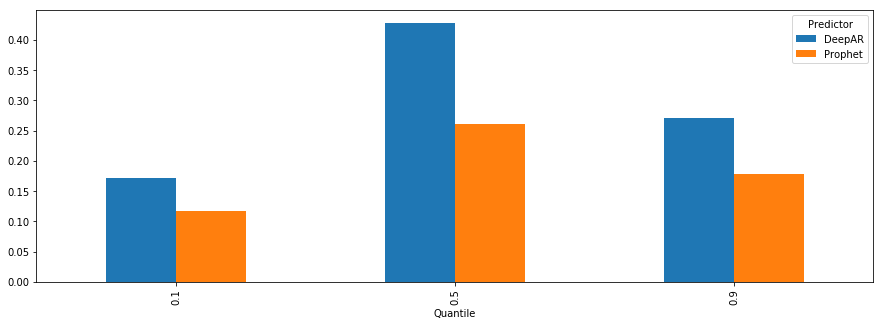

In [167]:
pd.concat([deep_ar_metrics, prophet_metrics]) \
    .pivot(index='Quantile', columns='Predictor', values='LossValue').plot.bar();

As we mentioned before, if you only have a handful of time series (in this case, only 1) with a small number of examples, the neural network models (DeepAR+) are not the best choice. Here, we clearly see that DeepAR+ behaves worse than Prophet in the case of a single time series. 

# Step 5. Creating a Forecast

Next we re-train with the full dataset, and create the forecast.

In [207]:
logging.info(f"Done fetching accuracy numbers. Creating forecaster for DeepAR+ ...")

INFO:root:Done fetching accuracy numbers. Creating forecaster for DeepAR+ ...


In [169]:
forecast_name_deep_ar = f'{project}_deep_ar_plus_{idx}'

In [170]:
create_forecast_response_deep_ar = forecast.create_forecast(ForecastName=forecast_name_deep_ar,
                                                        PredictorArn=predictor_arn_deep_ar)

In [171]:
forecast_arn_deep_ar = create_forecast_response_deep_ar['ForecastArn']

In [172]:
status = wait(lambda: forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar))
assert status

.............................................

INFO:root:Finished in 1380 seconds with status success


In [ ]:
forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar)

In [208]:
logging.info(f"Done fetching accuracy numbers. Creating forecaster for Prophet ...")

INFO:root:Done fetching accuracy numbers. Creating forecaster for Prophet ...


In [175]:
forecast_name_prophet = f'{project}_prophet_{idx}'

In [176]:
create_forecast_response_prophet = forecast.create_forecast(ForecastName=forecast_name_prophet,
                                                        PredictorArn=predictor_arn_prophet)

In [177]:
forecast_arn_prophet = create_forecast_response_prophet['ForecastArn']

In [178]:
status = wait(lambda: forecast.describe_forecast(ForecastArn=forecast_arn_prophet))
assert status

...............................

INFO:root:Finished in 960 seconds with status success


In [ ]:
forecast.describe_forecast(ForecastArn=forecast_arn_prophet)

# Step 6. Querying the Forecasts

In [180]:
item_id = 'bike_12'

In [182]:
forecast_response_deep = forecast_query.query_forecast(
    ForecastArn=forecast_arn_deep_ar,
    Filters={"item_id": item_id})

In [183]:
forecast_response_prophet = forecast_query.query_forecast(ForecastArn=forecast_arn_prophet,
                                                     Filters={"item_id":item_id})

In [184]:
fname = f'../data/bike_small.csv'
exact = load_exact_sol(fname, item_id)

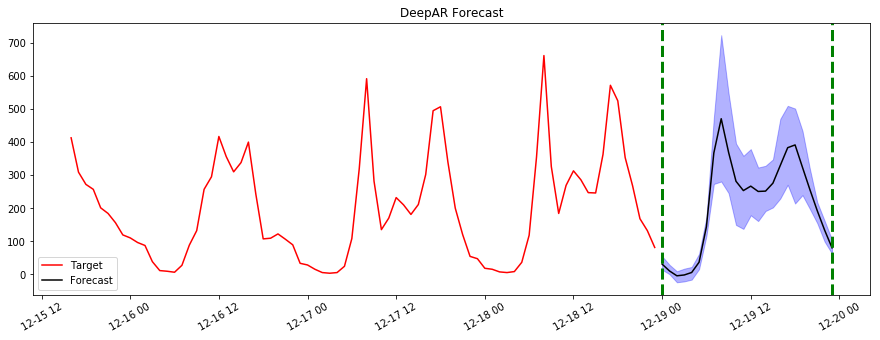

In [185]:
plot_forecasts(forecast_response_deep, exact)
plt.title("DeepAR Forecast");

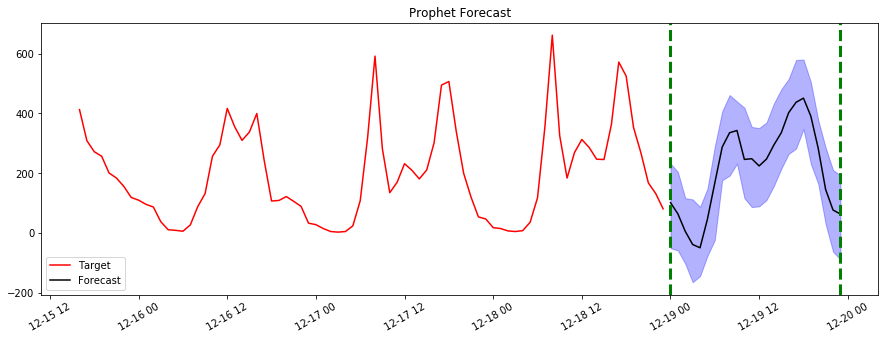

In [186]:
plot_forecasts(forecast_response_prophet,exact)
plt.title("Prophet Forecast");

# Step 7. Exporting your Forecasts

In [187]:
forecast_export_name_deep_ar = f'{project}_forecast_export_deep_ar_plus_{idx}'
forecast_export_name_deep_ar_path = f"{s3_data_path}/{forecast_export_name_deep_ar}"

In [188]:
create_forecast_export_response_deep_ar = forecast.create_forecast_export_job(ForecastExportJobName=forecast_export_name_deep_ar,
                                                        ForecastArn=forecast_arn_deep_ar,
                                                        Destination={
                                                            "S3Config" : {
                                                                "Path": forecast_export_name_deep_ar_path,
                                                                "RoleArn": role_arn
                                                            }
                                                        })
forecast_export_arn_deep_ar = create_forecast_export_response_deep_ar['ForecastExportJobArn']

In [189]:
forecast_export_name_prophet = f'{project}_forecast_export_prophet_{idx}'
forecast_export_name_prophet_path = f"{s3_data_path}/{forecast_export_name_prophet}"

In [190]:
create_forecast_export_response_prophet = forecast.create_forecast_export_job(ForecastExportJobName=forecast_export_name_prophet,
                                                        ForecastArn=forecast_arn_prophet,
                                                        Destination={
                                                            "S3Config" : {
                                                                "Path": forecast_export_name_prophet_path,
                                                                "RoleArn": role_arn
                                                            }
                                                        })
forecast_export_arn_prophet = create_forecast_export_response_prophet['ForecastExportJobArn']

# Step 8. Cleaning up your Resources

Once we have completed the above steps, we can start to cleanup the resources we created. All delete jobs, except for `delete_dataset_group` are asynchronous, so we have added the helpful `wait_till_delete` function. 
Resource Limits documented <a href="https://docs.aws.amazon.com/forecast/latest/dg/limits.html">here</a>. 

In [ ]:
# Delete forecast export for both algorithms
wait_till_delete(lambda: forecast.delete_forecast_export_job(ForecastExportJobArn = forecast_export_arn_deep_ar))
wait_till_delete(lambda: forecast.delete_forecast_export_job(ForecastExportJobArn = forecast_export_arn_prophet))

In [101]:
# Delete forecast for both algorithms
wait_till_delete(lambda: forecast.delete_forecast(ForecastArn = forecast_arn_deep_ar))
wait_till_delete(lambda: forecast.delete_forecast(ForecastArn = forecast_arn_prophet))

INFO:root:Successful delete

INFO:root:Successful delete



In [102]:
# Delete predictor for both algorithms
wait_till_delete(lambda: forecast.delete_predictor(PredictorArn = predictor_arn_deep_ar))
wait_till_delete(lambda: forecast.delete_predictor(PredictorArn = predictor_arn_prophet))

INFO:root:Successful delete

INFO:root:Successful delete



In [104]:
# Delete the target time series and related time series dataset import jobs
wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))
wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn=rts_dataset_import_job_arn))

INFO:root:Successful delete

INFO:root:Successful delete



In [105]:
# Delete the target time series and related time series datasets
wait_till_delete(lambda: forecast.delete_dataset(DatasetArn=ts_dataset_arn))
wait_till_delete(lambda: forecast.delete_dataset(DatasetArn=rts_dataset_arn))

INFO:root:Successful delete

INFO:root:Successful delete



In [106]:
# Delete dataset group
forecast.delete_dataset_group(DatasetGroupArn=dataset_group_arn)

{'ResponseMetadata': {'RequestId': 'ab35d923-c1b6-4193-974f-67603ddd148f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 06 Sep 2019 21:39:23 GMT',
   'x-amzn-requestid': 'ab35d923-c1b6-4193-974f-67603ddd148f',
   'content-length': '0',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}